In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sympy import symbols
from sympy.logic.boolalg import to_dnf

import itertools
from scipy import stats

import statsmodels.stats.multitest as multi

import pickle

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
#selected_folder = "functions_simple_and2"
#selected_folder = "functions_simple_or2"
#selected_folder = "functions_simple_xor2"
#selected_folder = "functions_minterms_and2"
#selected_folder = "functions_minterms_or2"
#selected_folder = "functions_minterms_xor2"
#selected_folder = "functions_minterms_and3"
#selected_folder = "functions_minterms_or3"
selected_folder = "functions_minterms_xor3"

load_from_pickle = True

In [4]:
folder = os.path.join("tests", selected_folder)
subfolders = os.listdir(folder)
subfolders = [x for x in subfolders if os.path.isdir(os.path.join(folder,x))]
subfolders = sorted(subfolders, key=lambda x: int(x))

In [5]:
def read_file(file_name, convert_to_syms = True): # convert_to_syms: converts a string presenting a function to a symbolic expression using the sympy library

    f = open(file_name)
    final_func = None

    data = {}
    for l in f:
        if l.startswith("-1"):
            final_func = l.strip().split(";")[1]
            continue

        s = l.strip().split(";")
        t = float(s[0].split("=")[1])
        data[t] = {}
        for func in s[1:]:
            if func:
                func,n = func.split(":")
                try:
                    func = func.strip().split("=")[1]
                except:
                    func = "None"

                if convert_to_syms:
                    ins = func.replace("|", "").replace("&","").replace("~","").replace("(","").replace(")","").split()
                    syms = symbols(ins)
                    for i, sym in zip(ins,syms):
                        globals()[i] = sym

                    func = to_dnf(func, True)

                n = int(n)
                
                if func not in data[t]:
                    data[t][func] = n
                else:
                    data[t][func] += n

    if final_func and convert_to_syms:
        final_func = to_dnf(final_func, True)

    T = list(data.keys())
    N = sum(data[T[0]].values())

    final_sol = sorted(list(data[t].items()), key = lambda x: x[1], reverse=True)
    best_sol = final_sol[0][0]
    
    #print(best_sol)
    #print(final_func)
    
    if not final_func: 
        final_func = best_sol # if final function is not specified take the converged solution...
        
        
    counts = []
    for t,functions in data.items():
        if final_func in functions:
            counts.append(functions[final_func]/N)
        else:
            counts.append(0)   
    f.close()
    return(N, T, counts, final_func)

In [6]:
def save_results(results, file_name):
    f = open(file_name, 'wb')
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

def load_results(file_name):
    f = open(file_name, 'rb')
    results = pickle.load(f)
    f.close()
    
    return results
    
    
    

In [7]:
subfolders

['4', '25', '49', '100']

In [8]:
if not load_from_pickle:

    results = {}

    for subfolder in subfolders:
        file_names = os.listdir(os.path.join(folder,subfolder))
        Cs = []

        for file_name in file_names:
            if file_name.endswith('txt'):
                N, T, counts, _ = read_file(os.path.join(folder,subfolder,file_name), convert_to_syms = True)
                Cs.append(counts)

        Cs = np.array(Cs)

        results[N] = (T, Cs)
        
    save_results(results,os.path.join(folder,'dump.p'))
else:
    results = load_results(os.path.join(folder,'dump.p'))

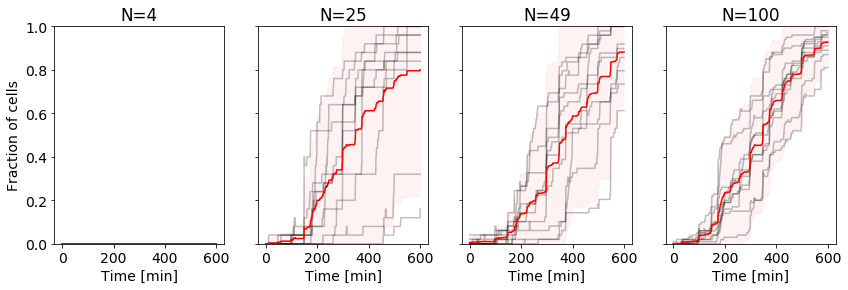

In [9]:
fig, axes = plt.subplots(1,len(results), sharey=True)

Ns = sorted(results.keys(), key=lambda x: int(x))

for i, N in enumerate(Ns):
    ax = axes.flat[i]
    
    T, Cs = results[N]
    
    for j,counts in enumerate(Cs):
        if not j:
            ax.plot(T, counts, color="black", alpha = 0.25, label='convergence')
        else:
            ax.plot(T, counts, color="black", alpha = 0.25, label='_no_legend')
    mean_Cs = np.mean(Cs, axis=0)
    std_CS = np.std(Cs, axis=0)
    Cs_low = mean_Cs - 1.96*std_CS
    Cs_up = mean_Cs + 1.96*std_CS
    
    ax.plot(T, mean_Cs, color="red", alpha = 1, label='mean convergence')
    ax.fill_between(T, Cs_low, Cs_up, color='red', alpha=0.05)
    
    #ax.legend()
    ax.set_xlabel("Time [min]")
    if not i:
        ax.set_ylabel("Fraction of cells")
    ax.set_title(f"N={N}")
    
    ax.set_ylim([0,1])
    
    fig=plt.gcf()

    fig.set_size_inches([14,4])
    

plt.savefig(f'convergence_{selected_folder}.pdf', bbox_inches = 'tight')
plt.show()


In [10]:
f = open(os.path.join(folder,f'statistics_{selected_folder}.txt'),'w')

convergence = {}

for i, N in enumerate(results):
    _, Cs = results[N]
    convergence[N] = Cs[:,-1]
    
p_KW = stats.kruskal(*convergence.values())[1]
if p_KW < 0.05:
    r = "rejected"
else:
    r = "not rejected"
    
print(f'Kruskal-Wallis H-test: {p_KW}, H0 {r}', file=f)

print(file=f)

print('\\bigskip', file=f)

print(file=f)

"""
p_KW = stats.kruskal(*list(convergence.values())[1:])[1]
if p_KW < 0.05:
    r = "rejected"
else:
    r = "not_rejected"

print(f'Kruskal-Wallis H-test without the smallest lattice (H0: the population median of all of the groups are equal): {p_KW}, H0 {r}', file=f)

print()
"""
Ps = []
Ns = []

for N1, N2 in itertools.combinations(list(convergence.keys()), 2):
    p_MW = stats.mannwhitneyu(convergence[N1], convergence[N2])[1]
    Ps.append(p_MW)
    Ns.append((N1,N2))
    
Qs = multi.multipletests(Ps, method = 'fdr_bh')[1]


#print("Mann-Whitney U test (nonparametric test, H0: both distributions are the same)", file=f)
print("\\noindent Mann-Whitney U test:", file=f)
print("\\begin{itemize}", file=f)


for (N1, N2), p_MW in zip(Ns, Qs):
    if p_MW < 0.05:
        r = "rejected"
    else:
        r = "not rejected"
    
    print(f'\\item {N1} vs. {N2}: {p_MW}, H0 {r}', file=f)

print("\\end{itemize}", file=f)
f.close()


